<span style="font-size:26px">This notebook focuses on detecting fraud in two financial datasets:</span>  
1. <strong>Transactions Dataset</strong>: Includes transaction details with fraud flags.  
2. <strong>Loan Applications Dataset</strong>: This dataset includes customer loan applications with associated fraud indicators.  

We will perform exploratory data analysis (EDA) and build machine learning models to predict fraudulent activity.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-application-and-transaction-fraud-detection/loan_applications.csv
/kaggle/input/loan-application-and-transaction-fraud-detection/transactions.csv


## Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
transactions = pd.read_csv('/kaggle/input/loan-application-and-transaction-fraud-detection/transactions.csv')
loans = pd.read_csv('/kaggle/input/loan-application-and-transaction-fraud-detection/loan_applications.csv')

## EDA - Transactions Dataset

Transactions Dataset Shape: (50000, 16)
fraud_flag
0    49498
1      502
Name: count, dtype: int64


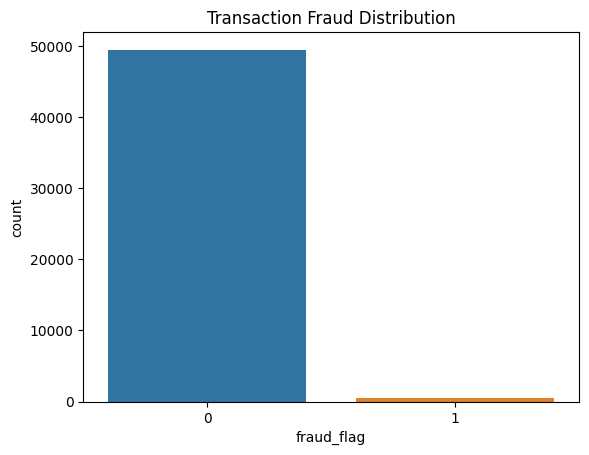

In [4]:
print("Transactions Dataset Shape:", transactions.shape)
print(transactions['fraud_flag'].value_counts())

sns.countplot(x='fraud_flag', data=transactions)
plt.title('Transaction Fraud Distribution')
plt.show()

## Correlation of numeric features

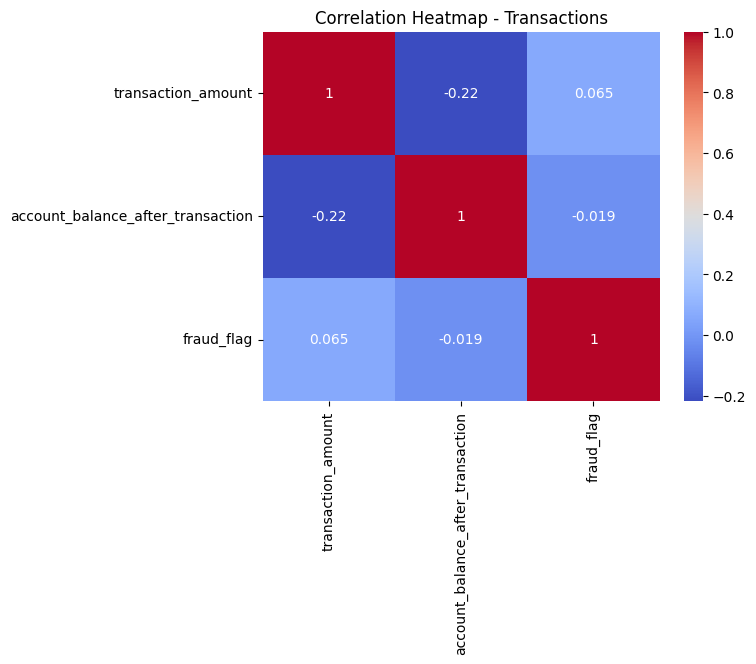

In [5]:
num_cols = ['transaction_amount', 'account_balance_after_transaction']
sns.heatmap(transactions[num_cols + ['fraud_flag']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Transactions')
plt.show()

## EDA - Loan Applications Dataset

Loan Applications Dataset Shape: (50000, 21)
fraud_flag
0    48974
1     1026
Name: count, dtype: int64


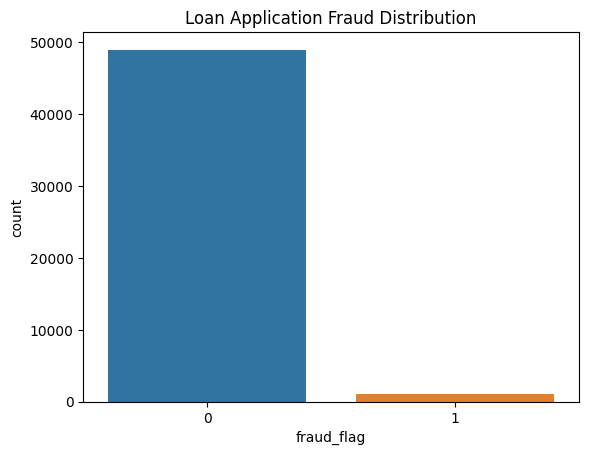

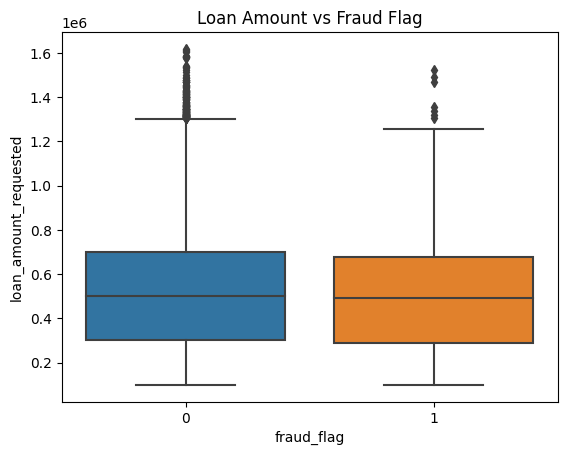

In [6]:

print("Loan Applications Dataset Shape:", loans.shape)
print(loans['fraud_flag'].value_counts())

sns.countplot(x='fraud_flag', data=loans)
plt.title('Loan Application Fraud Distribution')
plt.show()

# Distribution of Loan Amount by Fraud
sns.boxplot(x='fraud_flag', y='loan_amount_requested', data=loans)
plt.title('Loan Amount vs Fraud Flag')
plt.show()

In [7]:
loans.head()

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


# Preprocessing and Encoding categorical features - Transactions Dataset

In [8]:

trans_df = transactions.copy()
le = LabelEncoder()

cat_cols = ['transaction_type', 'merchant_category', 'merchant_name', 'transaction_location', 
            'device_used', 'transaction_status', 'transaction_source_destination']
for col in cat_cols:
    trans_df[col] = le.fit_transform(trans_df[col])

## ML Model Building and Evaluation - Transactions Dataset


Classification Report - Transactions Fraud
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14844
           1       0.99      0.49      0.66       156

    accuracy                           0.99     15000
   macro avg       0.99      0.75      0.83     15000
weighted avg       0.99      0.99      0.99     15000



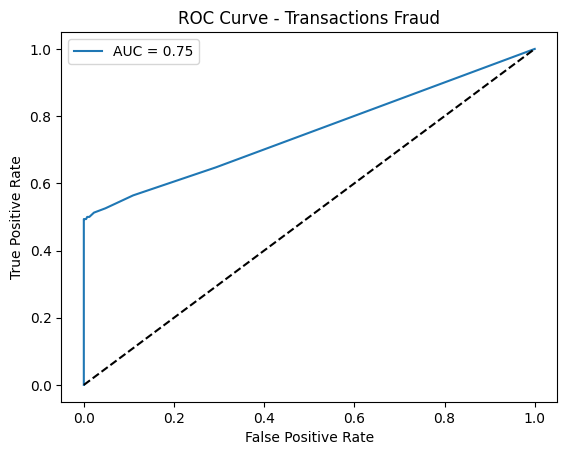

In [9]:
X_trans = trans_df[cat_cols + ['transaction_amount', 'account_balance_after_transaction', 'is_international_transaction']]
y_trans = trans_df['fraud_flag']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_trans, y_trans, test_size=0.3, random_state=42)


model_t = RandomForestClassifier(n_estimators=100, random_state=42)
model_t.fit(X_train_t, y_train_t)

preds_t = model_t.predict(X_test_t)
print("\nClassification Report - Transactions Fraud")
print(classification_report(y_test_t, preds_t))

probs_t = model_t.predict_proba(X_test_t)[:,1]
fpr, tpr, _ = roc_curve(y_test_t, probs_t)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test_t, probs_t):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve - Transactions Fraud')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## ML Model Building and Evaluation - Loan Application Dataset


Classification Report - Loan Fraud
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14725
           1       1.00      1.00      1.00       275

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



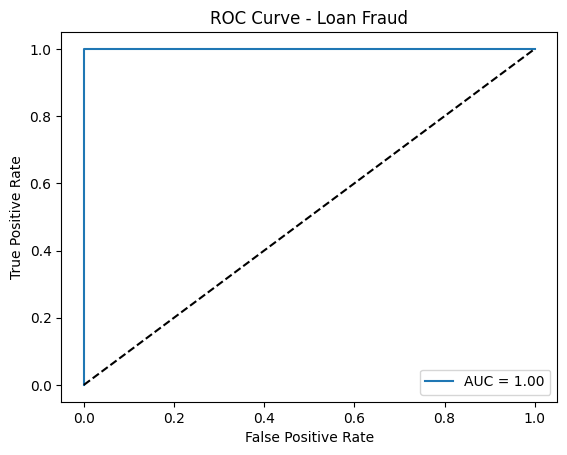

In [10]:
loan_df = loans.copy()
le = LabelEncoder()

cat_cols_loan = ['loan_type', 'purpose_of_loan', 'employment_status', 'property_ownership_status', 'gender', 'loan_status']
for col in cat_cols_loan:
    loan_df[col] = le.fit_transform(loan_df[col])

features_loan = ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 
                 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 
                 'applicant_age', 'number_of_dependents'] + cat_cols_loan
X_loan = loan_df[features_loan]
y_loan = loan_df['fraud_flag']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_loan, y_loan, test_size=0.3, random_state=42)


model_l = RandomForestClassifier(n_estimators=100, random_state=42)
model_l.fit(X_train_l, y_train_l)

preds_l = model_l.predict(X_test_l)
print("\nClassification Report - Loan Fraud")
print(classification_report(y_test_l, preds_l))

probs_l = model_l.predict_proba(X_test_l)[:,1]
fpr_l, tpr_l, _ = roc_curve(y_test_l, probs_l)
plt.plot(fpr_l, tpr_l, label=f'AUC = {roc_auc_score(y_test_l, probs_l):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve - Loan Fraud')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<span style="font-size:26px">-*✅ "Our model for detecting fraudulent loan applications is extremely effective. It can correctly identify both genuine applications and fraud attempts with nearly perfect accuracy in our testing."*</span> 

## Conclusion
- The datasets exhibit class imbalance with fewer fraud cases.
- Random Forest models show reasonable performance for both transaction and loan fraud detection.
- Further improvements can include:
  * Hyperparameter tuning
  * SMOTE for handling imbalance
  * Additional feature engineering
  * Cross-validation for robust evaluation